# Perspective Shift Identification

### Goal: 
Use ML to identify perspective shift in movement of distribution centers

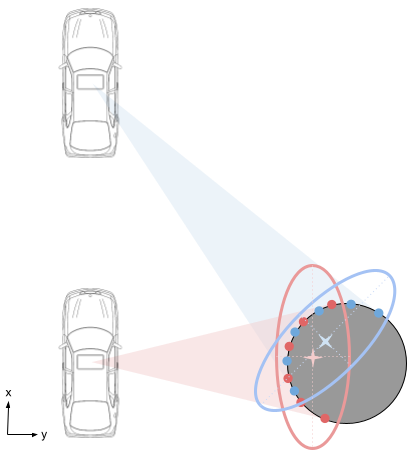

### Assumptions:
Gross rotation and translation have already been estimated by previous scan matching iterations

### Network structure:
Inputs: 
xyz of 25 points randomly sampled from each distribution

Output:
Correction factor translation between the two centers



### Training data generation

(starting with toy example)

1- generate grid of simple shapes in Inventor

2- Rotate randomly, translate randomly and simulate lidar scan of shapes at 2 points in time using MatLab script

3- Sample N points from each object and save to file. Also store information on rotation and translation to seperate file

4- import data here and augment again by duplicating and scaling examples arbitrarily

## TODO

Get tf.data() pipeline working

Scale allowable error threshold between DNN and D2D by radial disatance from origin

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
# import tensorflow_graphics as tfg
# import tensorflow_graphics.nn.layer.pointnet

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__) #requires tensorflow 2.3

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

2.7.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


In [3]:
#define functions to convert between spherical and cartesian coordinate representations
def c2s(pts):
    """ converts points from cartesian coordinates to spherical coordinates """
    r = tf.sqrt(pts[:,0]**2 + pts[:,1]**2 + pts[:,2]**2)
    phi = tf.math.acos(pts[:,2]/r)
    theta = tf.math.atan2(pts[:,1], pts[:,0])

    out = tf.transpose(tf.Variable([r, theta, phi]))
    return(out)
def s2c(pts):
    """converts spherical -> cartesian"""

    x = pts[:,:,0]*tf.math.sin(pts[:,:,2])*tf.math.cos(pts[:,:,1])
    y = pts[:,:,0]*tf.math.sin(pts[:,:,2])*tf.math.sin(pts[:,:,1]) 
    z = pts[:,:,0]*tf.math.cos(pts[:,:,2])

    out = tf.transpose(tf.Variable([x, y, z]))
    # out = tf.Variable([x, y, z])
    return(out)

In [ ]:
# old way - non-reduced dimension solution, only feed DNN each point cloud
# #_________________________________________________________________
# #load individual data numpy files
# d1_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_scan1.npy")
# d2_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_scan2.npy")
# gt_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_ground_truth.npy")
# # d1_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_scan1.npy")
# # d2_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_scan2.npy")
# # gt_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_ground_truth.npy")

# # d1_1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.npy")
# # d2_1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan2_300k_50_samples.npy")
# # gt_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ground_truth_300k_50_samples.npy")
# # gt_1 = gt_1*0.1 #scale to match real-world data (vel-> pos)

# # d1_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan1.npy")
# # d2_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan2.npy")
# # gt_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_ground_truth.npy")
# d1_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v4_scan1.npy")
# d2_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v4_scan2.npy")
# gt_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v4_ground_truth.npy")


# d1 = np.append(d1_1, d1_2, axis = 0)
# d2 = np.append(d2_1, d2_2, axis = 0)
# gt = np.append(gt_1, gt_2, axis = 0)
# #_________________________________________________________________

#small
d1 = np.loadtxt("training_data/ICET_Ford_scan1.txt")
d2 = np.loadtxt("training_data/ICET_Ford_scan2.txt")
gt = np.loadtxt("training_data/ICET_Ford_ground_truth.txt")

#big
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan1.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan2.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_ground_truth.npy")

# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/scan2_300k_50_samples.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ground_truth_300k_50_samples.npy")
# gt = gt*0.1 #scale to match real-world data (vel-> pos)

#reshape but don't convert to tensor
points_per_sample = 50          #poitns sammpled from each voxel
tsplit = 0.9 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)
print(np.shape(x_train))
# print(np.shape(x_test))

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]


In [4]:
#Testing new network structure informed by voxel boundaries
#   input both point clouds AND VOXEL BOUNDS to DNN
#_________________________________________________________________
#load data
# big
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/compact_scan1.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/compact_scan2.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/compact_ground_truth.npy")
# LUT = np.load("C:/Users/Derm/Desktop/big/pshift/LUT.npy")
# L = np.load("C:/Users/Derm/Desktop/big/pshift/L.npy")
# U = np.load("C:/Users/Derm/Desktop/big/pshift/U.npy")
# corn = np.load("C:/Users/Derm/Desktop/big/pshift/corn.npy")

#small
d1 = np.load('training_data/compact_scan1.npy')
d2 = np.load('training_data/compact_scan2.npy')
gt = np.load('training_data/compact_ground_truth.npy')
LUT = np.load('training_data/LUT.npy') 
L = np.load('training_data/L.npy')
U = np.load('training_data/U.npy')
corn = np.load('training_data/corn.npy')
#_________________________________________________________________

#loop through each element of corn and convert from spherical to cartesian
# print(np.shape(corn))
new_corn = np.transpose(s2c(corn), [1,0,2,])
# print(np.shape(new_corn))

#reshape but don't convert to tensor
points_per_sample = 50          #poitns sammpled from each voxel
tsplit = 0.9 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)

#combine voxel bound to each training example
x_train = np.append(x_train, new_corn[:ntrain], axis = 1)
x_test = np.append(x_test, new_corn[ntrain:], axis = 1)

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]
# y_train = gt[:ntrain][:,:,0] #when using compact data
# y_test = gt[ntrain:][:,:,0]
LUT = tf.convert_to_tensor(LUT)[ntrain:]
U = tf.convert_to_tensor(U)[ntrain:]
L = tf.convert_to_tensor(L)[ntrain:]
corn_train = corn[:ntrain]
corn_test = corn[ntrain:]

print(np.shape(x_train))
# print(np.shape(x_test))

(2648, 108, 3)


In [6]:
#train network
# from network import Net
from network import TestNet as Net
# from network import PointNet as Net
# from network import Attention as Net

runLen = 300

def scheduler(epoch, learning_rate):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        learning_rate = 0.002
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.001
        return learning_rate
    if epoch >= part2:
        learning_rate = 0.00025
        return learning_rate

model = Net() #comment out to re-train existing network
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.MeanAbsoluteError()) #was MeanSquaredError()

summary = model.summary()
print(summary)
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("FordNetCP.kmod", monitor = 'val_loss', save_best_only = True) 

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

trace = model.fit(x = x_train, y = y_train, batch_size = 16, epochs=runLen, verbose=1, 
                  validation_split = 0.2, shuffle=True, callbacks = [])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 108, 3)]     0           []                               
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 100, 3)      0           ['input_2[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.expand_dims_1 (TFOpLambda)  (None, 100, 3, 1)    0           ['tf.__operators__.getitem_2[0][0
                                                                 ]']                              
                                                                                            

Epoch 26/300
133/133 [==============================] - 2s 15ms/step - loss: 0.2895 - val_loss: 0.2488
Epoch 27/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2755 - val_loss: 0.2945
Epoch 28/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2825 - val_loss: 0.3055
Epoch 29/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2850 - val_loss: 0.3459
Epoch 30/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2736 - val_loss: 0.2447
Epoch 31/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2709 - val_loss: 0.3156
Epoch 32/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2769 - val_loss: 0.2776
Epoch 33/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2787 - val_loss: 0.2867
Epoch 34/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2705 - val_loss: 0.3221
Epoch 35/300
133/133 [==============================] - 2s 16ms/step - lo

133/133 [==============================] - 2s 16ms/step - loss: 0.2200 - val_loss: 0.2503
Epoch 106/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2181 - val_loss: 0.2755
Epoch 107/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2154 - val_loss: 0.2773
Epoch 108/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2159 - val_loss: 0.2648
Epoch 109/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2150 - val_loss: 0.2748
Epoch 110/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2104 - val_loss: 0.2591
Epoch 111/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2114 - val_loss: 0.2569
Epoch 112/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2233 - val_loss: 0.2713
Epoch 113/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2182 - val_loss: 0.3009
Epoch 114/300
133/133 [==============================] - 2s 16ms/step - loss: 

Epoch 184/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2088 - val_loss: 0.2337
Epoch 185/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1962 - val_loss: 0.2594
Epoch 186/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2010 - val_loss: 0.2396
Epoch 187/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1964 - val_loss: 0.2153
Epoch 188/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1939 - val_loss: 0.2182
Epoch 189/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2005 - val_loss: 0.2167
Epoch 190/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1901 - val_loss: 0.2611
Epoch 191/300
133/133 [==============================] - 2s 16ms/step - loss: 0.2008 - val_loss: 0.2439
Epoch 192/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1935 - val_loss: 0.2419
Epoch 193/300
133/133 [==============================] - 2s 16ms

Epoch 263/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1902 - val_loss: 0.2915
Epoch 264/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1933 - val_loss: 0.2810
Epoch 265/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1978 - val_loss: 0.2387
Epoch 266/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1914 - val_loss: 0.2988
Epoch 267/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1873 - val_loss: 0.2819
Epoch 268/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1979 - val_loss: 0.3254
Epoch 269/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1971 - val_loss: 0.3201
Epoch 270/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1961 - val_loss: 0.2981
Epoch 271/300
133/133 [==============================] - 2s 16ms/step - loss: 0.1995 - val_loss: 0.3133
Epoch 272/300
133/133 [==============================] - 2s 16ms

### Top Scores
#### C:/Users/Derm/Desktop/big/pshift/scan1_10k_50_samples.txt 
 no rotation in objects used to train DNN 

-- 0.69 MAE using the CNN kernel hack presented in PCR-Net

-- 0.60 MAE using my strategy

-- 0.36 MAE using simplified PCR-Net

#### C:/Users/Derm/Desktop/big/pshift/scan1_1k_50_samples.txt 

-- 0.56 MAE, bs=32

#### C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.txt 

-- 0.39 MAE, bs = 64, epoch = 99 (saved as <Net.kmod>)

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford.txt

-- 0.047 MAE, bs = 256, epoch = 300

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2.txt
(100 shifts from 10 frames)

-- 0.030 MAE, bs = 512, epoch = 300

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1+2.txt
--0.032 MAE, bs = 1024, with cnn, epoch = 100

#### Ford2 + 300k synthetic

-- 0.06 MAE with NET, ?? epoch

-- 0.078 MAE MaxPool1D -> Attention, 30 epoch

### v1+v4
0.04 MAE, bs = 512, w/ 256 Conv and 256 FF, epoch = 30

0.033 MAE, bs = 1024, 64 conv 64 FF, epoch = 100

0.027 MAE, bs = 1024, 64 conv, 64 FF, epoch = 300 [FordNetV3]

<IPython.core.display.Javascript object>


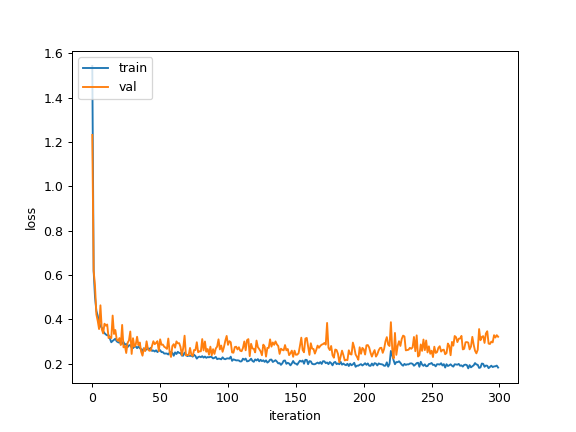

Text(0, 0.5, 'loss')

In [7]:
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('loss')

In [8]:
# estimates = model.predict(x_train[0:100:16])
# print(estimates)
# print(y_train[0:100:16])
estimates = model.predict(x_test[:10]) #* 10
print("estimated translation x y z")
print(estimates)
print("actual translation x y z")
print(y_test[:10])

err = y_test[:10] - estimates
# err = y_train[0:100:16] - estimates

print("\n Error \n",err)

print(tf.math.reduce_mean(tf.math.reduce_sum(err, axis = 1)))




estimated translation x y z
[[ 0.7919031   0.30638608  0.04862268]
 [-1.4388137  -0.97229654 -0.02886035]
 [ 0.2313627  -0.6846208  -0.07535617]
 [ 0.44597715  0.39185956 -0.11448459]
 [-0.790259    0.4078826   0.07964186]
 [ 1.1816709  -0.8419733  -0.05510063]
 [ 1.5454404  -0.7642681   0.06184895]
 [ 1.0343943   0.12214139 -0.01793253]
 [ 0.3971764  -0.6207823   0.03081149]
 [ 0.6426892  -0.36158597  0.11594281]]
actual translation x y z
[[ 0.9400477   0.4481968   0.03985295]
 [-1.7029183  -1.3110085  -0.05305311]
 [ 0.19578943 -0.8448893  -0.09140391]
 [ 0.30493116  0.63436174 -0.19148223]
 [-0.8523577   0.51897085  0.11555608]
 [ 1.2691424  -1.1443651  -0.05874199]
 [ 1.8308667  -0.96685535  0.08750146]
 [ 1.2370903   0.11873367 -0.02171171]
 [ 0.38440353 -0.8065682   0.07363974]
 [ 0.719395   -0.50614977  0.16731453]]

 Error 
 [[ 0.1481446   0.14181072 -0.00876973]
 [-0.2641046  -0.33871192 -0.02419276]
 [-0.03557327 -0.16026849 -0.01604774]
 [-0.14104599  0.24250218 -0.07699764]

<IPython.core.display.Javascript object>


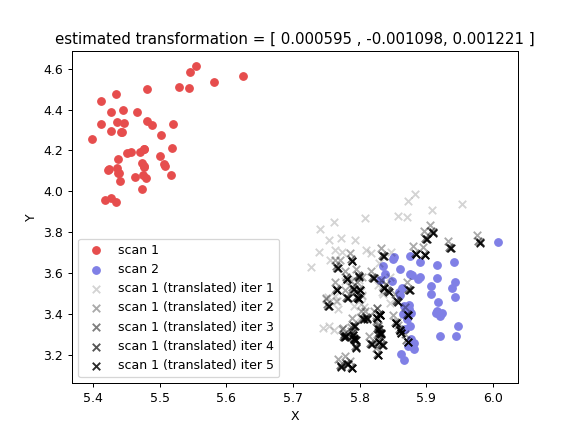

n =  10

 correct soln [ 0.43503544 -0.7761041   0.2169605 ]

 estiamted soln: [[ 0.35505286 -0.81565404  0.24851811]]

 error from DNN: [[ 0.07998257  0.03954994 -0.0315576 ]]

 error in means [ 0.07782051 -0.11454785  0.03392632]


In [16]:
#visualize results of network on test data
#2d plots (x and y only)
fig1, ax1 = plt.subplots()
n = int(np.floor(100*np.random.rand()))
# n = 8 #sample number (from x_test)

print("n = ", n)

# print(tf.shape(x_test))
# c1 = np.array([x_test[n,:points_per_sample,0].numpy(), x_test[n,:points_per_sample,1].numpy(), x_test[n,:points_per_sample,2].numpy()])
# c2 = np.array([x_test[n,points_per_sample:,0].numpy(), x_test[n,points_per_sample:,1].numpy(), x_test[n,points_per_sample:,2].numpy()])
c1 = np.array([x_test[n,:points_per_sample,0], x_test[n,:points_per_sample,1], x_test[n,:points_per_sample,2]])
c2 = np.array([x_test[n,points_per_sample:(points_per_sample*2),0], x_test[n,points_per_sample:(points_per_sample*2),1], x_test[n,points_per_sample:(points_per_sample*2),2]])
ax1.scatter(c1[0,:], c1[1,:], color = [0.9, 0.3, 0.3], label = 'scan 1')
ax1.scatter(c2[0,:], c2[1,:], color = [0.5, 0.5, 0.9], label = 'scan 2')


inputs = x_test[n][None,:]
# print(x_test[n, 100:])
runlen = 5
corr_sum = np.zeros([1,3]) #init var to store correction contributions
for i in range(runlen):
    correction = model.predict(inputs)[0] #show what the network thinks
#     correction = correction*0.1
#     correction = y_test[n] #show actual solution
    corr_sum += correction
#     print(correction)
    c1 = np.array([c1[0,:] + correction[0], c1[1,:] + correction[1], c1[2,:] + correction[2]])
    inputs = np.append(c1, c2, axis = 1).T[None,:,:]
#     print(tf.shape(inputs))
#     print(tf.shape(x_test[n,None,100:]))
    inputs = np.append(inputs, x_test[n,None,100:], axis = 1)
    moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0., 0., 0., (i+1)/(runlen+1)],
                        label = 'scan 1 (translated) iter %i' %(i+1))

# moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0.9, 0.3, 0.3, (i+2)/(runlen+2)],
#                         label = 'scan 1 (translated)')

ax1.set_title("estimated transformation = [ %f , %f, %f ]" %(correction[0], correction[1], correction[2]))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend(loc = 'best')

print("\n correct soln", y_test[n])
# print("\n y_test", y_test[n]*0.1)
print("\n estiamted soln:", corr_sum)
print("\n error from DNN:", y_test[n] - corr_sum)
print("\n error in means",  y_test[n] + (np.mean(x_test[n,:points_per_sample], axis = 0) - 
      np.mean(x_test[n,points_per_sample:], axis = 0)))

In [ ]:
#use Vedo to plot inital and transformed point clouds in 3D 
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

plt1 = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
disp = []

#draw scan1 
# disp.append(Points(x_test[n,:points_per_sample].numpy(), c = 'green', r = 5))
disp.append(Points(x_test[n,:points_per_sample], c = 'green', r = 5))

#draw initial scan2
# disp.append(Points(x_test[n,points_per_sample:].numpy(), c = 'red', r = 5))
disp.append(Points(x_test[n,points_per_sample:points_per_sample*2], c = 'red', r = 5))

#draw transformed scan2
disp.append(Points(c1, c = 'blue', r = 5))

plt1.show(disp, "Network Performance Test")
ViewInteractiveWidget(plt1.window)



In [ ]:
#save network
# model.save("ffnet10k25.kmod")
# model.save("Net.kmod")
# model.save("PIPEnet10.kmod")
# model.save("KITTInet.kmod")
# model.save("FordNet.kmod")
# model.save("FordNetV3.kmod")
# model.save("FULL_KITTInet4500.kmod")


#load network
# model = tf.keras.models.load_model("Net.kmod")
# model = tf.keras.models.load_model("FordNet.kmod")
# model = tf.keras.models.load_model("PIPEnet10.kmod")
# model = tf.keras.models.load_model("KITTInet.kmod")
# model = tf.keras.models.load_model("FORDNetV3.kmod")

In [ ]:
#test random shuffle layer to enforce training on unordered data
#GOAL: randomize order of each sample in batch SEPRATELY 
#      (i.e. don't have same order for all elements of batch)

test = tf.constant([[1., 3., 4.], [2., 3., 5.], [6., 6., 6.], [0., 0., 0.]])#[None, :, :]
test = tf.Variable([test, 2*test])
print(test)

test = tf.transpose(test, [1,0,2])
test = tf.random.shuffle(test)
test = tf.transpose(test, [1,0,2])
print(test)

### Top scores:

#### 1k dataset
8.23 MSE with no parallelization (vel = [5, 5, 5])

4.2 MSE (vel = [5, 5, 0.01])

3.9 MSE - 50 sample points from each scan

3.34- maxpool on first/ second half, conv after


#### 10k dataset

2.4 MSE 50 samples

1.05 MSE 25 samples -ffNet10k25.kmod

### KITTI drive 005, 100 frames

0.145 - Permnet

0.0895 -PCRnet

0.0520 KITTInet (5/20)

### KITTI drive 005, 150 frames, 50 sample points
0.759 pipeNET

### Ford Campus Drive 01 (200 frame sample)
0.073 - NET, 200 frames, with ground plane

### KITTI Full 00 400 frames, with ground plane
0.0752 net

### KITTI Full 00 400 frames, no ground plane
0.0756

### KITTI Full 00 4500 frames, with ground plane
0.0736 net


### Notes
From PointNet: Small rotations and gaussian noise can successfully augment models to increase training dataset

Need to figure out a way to achieve permutation invariance
Try transformer network i.e. "Attention is all you need"
https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html

Can potentially use reflectance as 4th dimension(?)

### Find average error in mean point locations when ground truth solution is applied
Test for indexing when geterating training data using Ford dataset - this error should be minimal when we are correctly indexing gt

In [ ]:
d1 = np.loadtxt('training_data/ICET_Ford_scan1.txt') #available in repo
d2 = np.loadtxt('training_data/ICET_Ford_scan2.txt')
truth = np.loadtxt('training_data/ICET_Ford_ground_truth.txt')

points_per_sample = 50 #25 #50  #num pts per scan - defined in MatLab script
s1 = tf.reshape(tf.convert_to_tensor(d1), [-1, points_per_sample, 3])
s2 = tf.reshape(tf.convert_to_tensor(d2), [-1, points_per_sample, 3])
truth = tf.convert_to_tensor(truth)

In [ ]:
print(tf.shape(s1))
mu1 = tf.math.reduce_mean(s1, axis = 1)
mu2 = tf.math.reduce_mean(s2, axis = 1)
# print("\n mu1", mu1)
# print("\n mu2", mu2)
centers_error = mu1 - mu2 + truth 
# print("\n centers_error", centers_error)

#get mean absolute centers error across all voxels
# mace = tf.math.reduce_mean(abs(centers_error), axis = 0) #absolute error
mace = tf.math.reduce_mean(centers_error, axis = 0)
print("\n mace", mace)